In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
import os

folder = 'data/'

labels = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]

print(labels)


['Lung Squamous Cell Carcinoma', 'Pancreatic Adenocarcinoma', 'Kidney Renal Clear Cell Carcinoma', 'Uveal Melanoma', 'Breast Invasive Carcinoma', 'Lung Adenocarcinoma']


In [4]:
def retrieve_data(data_path, filenames):
    list_of_dfs = []
    for i in range(0, len(filenames)):
        if ('annotations.txt' in filenames[i]):
            break
        inner_data_path = data_path + filenames[i]
        df = pd.read_csv(inner_data_path, sep='	', header=0)
        df = df[['miRNA_ID','reads_per_million_miRNA_mapped']]
        list_of_dfs.append(df)
    return list_of_dfs
    

In [5]:
def make_df(list_of_dfs, cancer_type):
    data = [] 
    labels = list_of_dfs[0]['miRNA_ID']
    for df in list_of_dfs:
        data.append(df['reads_per_million_miRNA_mapped'])

    big_df = pd.DataFrame(data)
    big_df.columns = labels
    big_df = big_df.reset_index(drop=True)
    big_df['diagnosis'] = cancer_type
    #big_df.rename(columns = {'miRNA_ID':'Index'}, inplace = True)
    
    return big_df

In [6]:
dp = 'data/Breast Invasive Carcinoma/MANIFEST.txt'
df = pd.read_csv(dp, sep='	', header=0)
filenames = df['filename']
breast = retrieve_data('data/Breast Invasive Carcinoma/', filenames)

In [7]:
def create_data_frame(labels):
    list_of_dfs = []
    for name in labels:
        dp = 'data/' + name + '/'
        df = pd.read_csv(dp + 'MANIFEST.txt', sep='	', header=0)
        filenames = df['filename']
        retrieve = retrieve_data(dp, filenames)
        new_df = make_df(retrieve, name)
        list_of_dfs.append(new_df)
    final_df = pd.concat(list_of_dfs)
    return final_df

create_data_frame() brings everything together and returns a final data frame with all of the types of cancer included.

Add label column for each based on which folder they came from, we need to take each df and transpose it so that each df is a row with a label

In [8]:
big_list = create_data_frame(labels)
big_list.head()

miRNA_ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,diagnosis
0,9337.616622,9138.715586,9344.771335,31965.113617,1151.908878,606.004236,538.749928,2435.464484,2375.364890,713.324938,...,7.870185,0.000000,132.362200,11.447542,0.0,8.585656,66.538836,286.188541,10480.224372,Lung Squamous Cell Carcinoma
1,9197.286767,9285.825906,9305.312083,15457.836262,1602.407054,307.805936,1449.544610,6487.383740,6523.707489,610.693031,...,15.134895,0.189186,49.566783,4.351282,0.0,21.188854,49.755969,276.779400,38726.413684,Lung Squamous Cell Carcinoma
2,6494.512652,6466.129570,6593.853441,16025.435876,552.601237,437.331168,554.918223,1990.001625,2008.247892,300.049728,...,18.825514,0.000000,207.659899,4.923596,0.0,13.322671,49.235959,148.287124,16656.525024,Lung Squamous Cell Carcinoma
3,8143.014860,8138.517821,8146.387640,33502.946685,1621.182856,1485.147402,845.443487,3048.993000,3046.744480,364.260226,...,32.603539,0.000000,256.331270,0.000000,0.0,16.863899,74.201157,617.218716,36108.981263,Lung Squamous Cell Carcinoma
4,9644.895834,9677.261256,9761.719596,9897.346128,944.145604,442.019195,659.329888,4091.605858,4252.508243,684.605741,...,8.939021,0.000000,99.562204,0.308242,0.0,30.824212,55.483581,233.955767,10677.815168,Lung Squamous Cell Carcinoma


In [9]:
#Finding how balanced the data is
counts = big_list['diagnosis'].value_counts(sort=False)
counts

Lung Squamous Cell Carcinoma          478
Pancreatic Adenocarcinoma             178
Kidney Renal Clear Cell Carcinoma     544
Uveal Melanoma                         80
Breast Invasive Carcinoma            1096
Lung Adenocarcinoma                   519
Name: diagnosis, dtype: int64

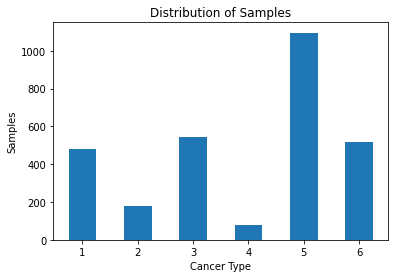

In [10]:
#Printing the graph
X_axis = np.arange(len(labels))
  
plt.bar(X_axis, counts, .5)
  
plt.xticks(X_axis, [1,2,3,4,5,6])
plt.xlabel("Cancer Type")
plt.ylabel("Samples")
plt.title("Distribution of Samples")

plt.show()

In [11]:
def double_check(data_frames):
    for df in data_frames:
        if (data_frames[0]['miRNA_ID'].equals(df['miRNA_ID']) == False):
            return False
    return True

In [12]:
#implementation of the scikit k-nearest neighbors

big_list = big_list.fillna(0)

features = big_list.drop("diagnosis", axis='columns')
targets = big_list['diagnosis']

features_norm = (features-features.min())/(features.max()-features.min())
features_norm = features_norm.fillna(0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features_norm, targets, test_size=0.4, random_state=42)
#KNN
neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(X_train, y_train)

preds1 = neigh.predict(X_test)

print(accuracy_score(y_test, preds1))
print(confusion_matrix(y_test, preds1))

0.8626943005181347
[[395   2  18   7   3   0]
 [  9 198   0   0   0   0]
 [ 26   0 139  15  24   0]
 [ 20   0  20 156   8   0]
 [  3   0   2   0  74   0]
 [  1   0   0   1   0  37]]


In [14]:
#RFC
clf = RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(X_train, y_train)
preds2 = clf.predict(X_test)
print(accuracy_score(y_test, preds2))

print(confusion_matrix(y_test, preds2))

0.9689119170984456
[[424   0   0   1   0   0]
 [  1 206   0   0   0   0]
 [  6   0 194   4   0   0]
 [  4   0  13 187   0   0]
 [  1   1   4   0  73   0]
 [  1   0   0   0   0  38]]


Accuracy of KNN Models: [0.8411053540587219, 0.8523316062176166, 0.8626943005181347, 0.8583765112262521, 0.8540587219343696, 0.8514680483592401, 0.8488773747841105, 0.844559585492228, 0.8471502590673575, 0.8411053540587219, 0.8376511226252159, 0.8341968911917098, 0.8324697754749568, 0.8281519861830743, 0.8221070811744386, 0.8212435233160622, 0.812607944732297]


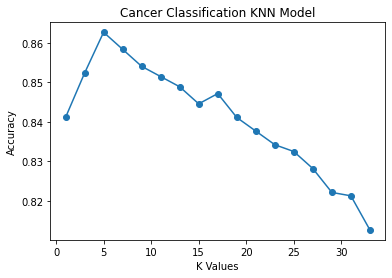

In [15]:
scores = []
for k in range(1,35,2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    preds = neigh.predict(X_test)
    scores.append(accuracy_score(y_test, preds))

plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('Cancer Classification KNN Model')
plt.plot(np.arange(1,35,2),scores, "o-")
print("Accuracy of KNN Models:", scores)

In [20]:
from sklearn.svm import LinearSVC, SVC
#why does this work, because there are a large number of features and a moderate number of examples so no
# real need to increase the complexity, can be accomplished linearly?
svc = LinearSVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.9689119170984456

In [17]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(random_state=0).fit(X_train, y_train)
logReg.score(X_test, y_test)

0.966321243523316